In [2]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as sm
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Cargar el archivo 
df = pd.read_csv('/home/saul/Escritorio/ROSY/Metastasis/base-de-datos-mets-opt_cleaned_final .csv', encoding='latin-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EXPEDIENTE                  466 non-null    int64  
 1   EDAD                        466 non-null    int64  
 2   SEXO                        466 non-null    object 
 3   TUMOR PRIMARIO              466 non-null    object 
 4   SUBTIPO HISTOLOGICO         466 non-null    object 
 5   PERFIL MOLECULAR            466 non-null    object 
 6   AÑO                         466 non-null    float64
 7    No. METS                   466 non-null    object 
 8   TAMAÑO (mm)                 466 non-null    object 
 9   LOCALIZACION                466 non-null    object 
 10  CIRUGIA PREVIA              466 non-null    object 
 11  SRS                         466 non-null    object 
 12  DOSIS (Gy)                  466 non-null    int64  
 13  TECNICA                     466 non

In [4]:
# Se observa que hay valores no numéricos que hay que eliminar
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].str.replace(r'[^\d.]', '', regex=True)

# los valores que quedan vacios se deben reemplar ćon NaN para poder convertir a float
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].replace('', np.nan)

# Verificar las filas con el valor problemático
problemas = df[df['TAMAÑO (mm)'] == '20240611000000']

# Reemplazar valor problematico
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].replace('20240611000000', np.nan)

# Convertir la columna a tipo float
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].astype(float)

In [5]:
# Agrupar por las columnas deseadas y calcular el promedio de tamaño
grouped_data = df.groupby(['EDAD', 'SEXO', 'TUMOR PRIMARIO', ' No. METS'])['TAMAÑO (mm)'].agg(['mean'])

# Renombrar la columna 'mean' a 'Promedio de Tamaño'
grouped_data = grouped_data.rename(columns={'mean': 'Promedio de Tamaño'})

# Reiniciar el índice para que las columnas de agrupación sean columnas regulares
grouped_data = grouped_data.reset_index()

# Mostrar la tabla
print(grouped_data)

     EDAD SEXO         TUMOR PRIMARIO  No. METS  Promedio de Tamaño
0      24    F         CANCER DE MAMA         1                13.0
1      24    F         CANCER DE MAMA         2                13.9
2      24    F         CANCER DE MAMA         3                16.4
3      24    F         CANCER DE MAMA         4                54.1
4      30    M      CANCER DE ESOFAGO         1                16.2
..    ...  ...                    ...       ...                 ...
384    79    F               MELANOMA         1                27.9
385    84    M     CANCER DE PROSTATA         1                35.2
386    87    F       CANCER DE PULMON         1                12.0
387    87    F       CANCER DE PULMON         2                 9.0
388    93    F  CANCER CERVICOUTERINO         1                22.0

[389 rows x 5 columns]


In [6]:
# Agrupar por 'TUMOR PRIMARIO' y calcular el promedio de 'Promedio de Tamaño'
tumor_primario_grouped = grouped_data.groupby('TUMOR PRIMARIO')['Promedio de Tamaño'].mean()

# Mostrar la tabla resultante
print(tumor_primario_grouped)

TUMOR PRIMARIO
CANCER CERVICOUTERINO     22.000000
CANCER DE COLON           25.000000
CANCER DE ENDOMETRIO      25.914286
CANCER DE ESOFAGO         13.450000
CANCER DE MAMA            15.423450
CANCER DE OVARIO          14.607500
CANCER DE PROSTATA        35.200000
CANCER DE PULMON           9.594556
CANCER DE TIROIDES         6.684848
CANCER RENAL              19.597719
CANCER TESTICULAR         23.350000
MELANOMA                  12.517059
TUMOR NEUROECTODERMICO    17.000000
TUMOR NEUROENDOCRINO      18.600000
Name: Promedio de Tamaño, dtype: float64


In [7]:
# Agrupar por 'TUMOR PRIMARIO' y 'No. METS', calcular el promedio de 'Promedio de Tamaño'
tumor_mets_grouped = grouped_data.groupby(['TUMOR PRIMARIO', ' No. METS'])['Promedio de Tamaño'].mean()

# Mostrar la tabla resultante
print(tumor_mets_grouped)

TUMOR PRIMARIO          No. METS
CANCER CERVICOUTERINO  1            22.0
CANCER DE COLON        1            25.0
CANCER DE ENDOMETRIO   1            32.1
                       2            22.0
                       3             9.0
                                    ... 
TUMOR NEUROENDOCRINO   5            23.2
                       6            19.7
                       7            28.6
                       8            16.0
                       9            18.2
Name: Promedio de Tamaño, Length: 137, dtype: float64


In [8]:
df.head()

,EXPEDIENTE,EDAD,SEXO,TUMOR PRIMARIO,SUBTIPO HISTOLOGICO,PERFIL MOLECULAR,AÑO,No. METS,TAMAÑO (mm),LOCALIZACION,CIRUGIA PREVIA,SRS,DOSIS (Gy),TECNICA,TRATAMIENTO SISTEMICO,RESPUESTA (CRITERIOS RANO),ID_unico,RESPUESTA_BINARIA
0,209406,55,F,CANCER DE MAMA,CARCINOMA DUCTAL INFILTRANTE,TRIPLE NEGATIVO,2016.0,1,26.00,PARIETAL IZQ,SI,DU (dosis única),16,VMAT,CAPECITABINE,RESPUESTA COMPLETA,arVYSawGyncamwxDvEFq2p,1
1,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,1,17.00,FRONTAL DER,NO,DU (dosis única),20,VMAT,SORAFENIB,ESTABLE,fXjbGDzCmb8uvRK9WLJVsF,1
2,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,2,4.55,FRONTAL DER,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,9jYiY9yM7nYu3k2CcnxQUz,1
3,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,3,3.44,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,i8VWomMqG92GyenK6f9vMJ,1
4,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,4,4.90,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,ESTABLE,E2BccD5k4nE3KBf7FvpeUa,1


ANALISIS ESTADISTICO PARA EVALUAR ASOCIACIONES SIGNIFICATIVAS ENTRE VARIABLES

Relación entre el "TUMOR PRIMARIO" y "LOCALIZACIÓN" de tumores secundarios.


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 285.1528
Valor p: 0.0000

Tabla de contingencia:
LOCALIZACION            CEREBELO  FRONTAL DER  FRONTAL IZQ  HOLOCRANEO  \
TUMOR PRIMARIO                                                           
CANCER CERVICOUTERINO          0            0            0           0   
CANCER DE COLON                0            0            0           0   
CANCER DE ENDOMETRIO           1            4            1           0   
CANCER DE ESOFAGO              0            0            0           0   
CANCER DE MAMA                51           15           17           1   
CANCER DE OVARIO               6            2            1           0   
CANCER DE PROSTATA             0            0            1           0   
CANCER DE PULMON              23           25           11           0   
CANCER DE TIROIDES             6            6            8           0   
CANCER RENAL                   7            5            4           0   
CANCER TES

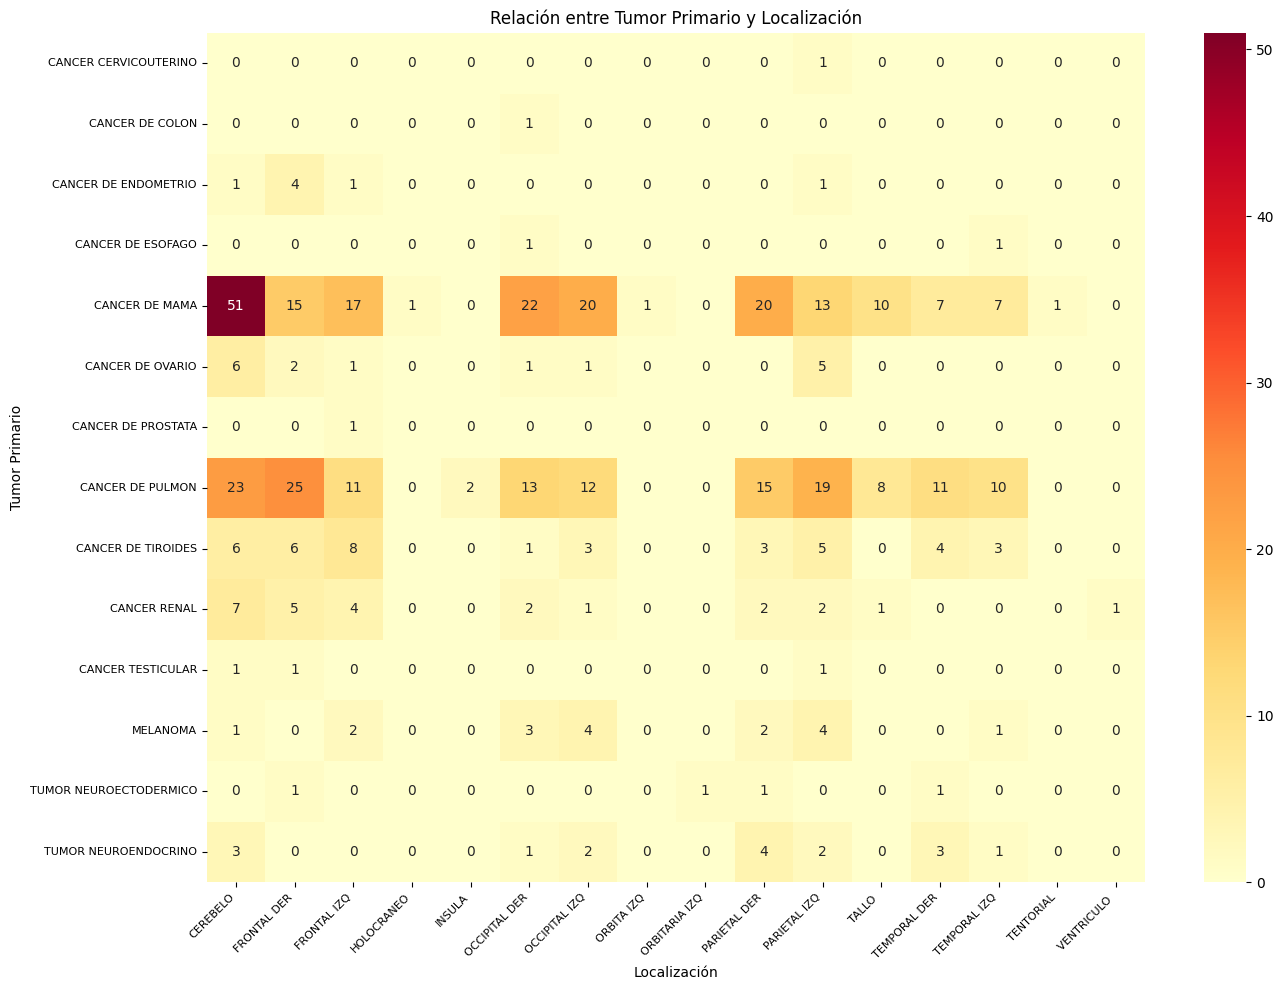

In [9]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['TUMOR PRIMARIO'], df['LOCALIZACION'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre Tumor Primario y Localización')
plt.xlabel('Localización')
plt.ylabel('Tumor Primario')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()
     

Dado que el valor p es menor que 0.05 (valor p 0.0000), indica una relación estadísticamente significativa entre el tipo de tumor primario y la localización de la metástasis. Es decir, el tipo de tumor primario influye en la localización de la metástasis.

Encontramos principalmente una relación de tumor primario en mama con la localización en lóbulo occipital, lóbulo parietal, lóbulo frontal y cerebelo. Además, otra relación importante es entre tumor primario en pulmón y localización en lóbulo frontal (con ayor incidencia en lóbulo frontal derecho respecto al izquierdo), lóbulo parietal, lóbulo occipital, lóbulo temporal y cerebelo.

ANALISIS DE LA RELACION ENTRE LA VARIABLE SUBTIPO HISTOLOGIO Y RESPUESTA BINARIA

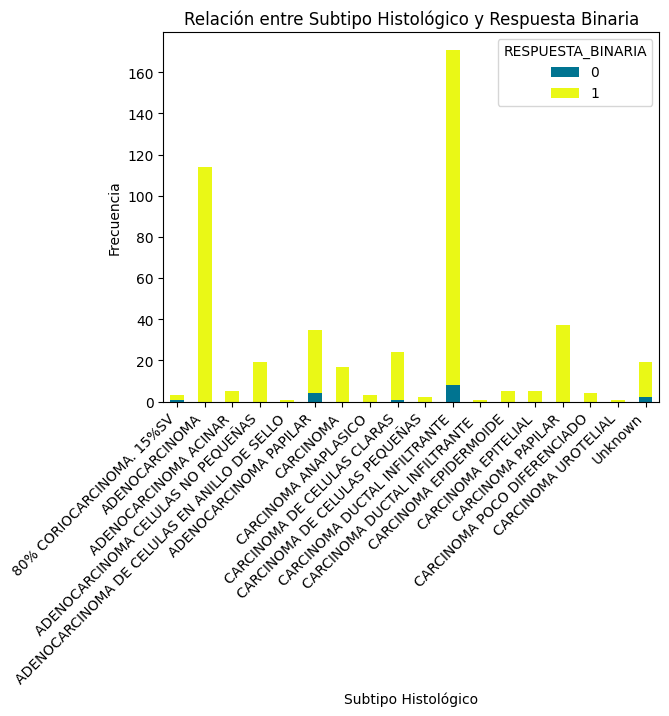

Resultado del test Chi-squared:
Chi2: 26.166753771001574
p-value: 0.07147556711519071
Grados de libertad: 17
Frecuencias esperadas:
[[1.03004292e-01 2.89699571e+00]
 [3.91416309e+00 1.10085837e+02]
 [1.71673820e-01 4.82832618e+00]
 [6.52360515e-01 1.83476395e+01]
 [3.43347639e-02 9.65665236e-01]
 [1.20171674e+00 3.37982833e+01]
 [5.83690987e-01 1.64163090e+01]
 [1.03004292e-01 2.89699571e+00]
 [8.24034335e-01 2.31759657e+01]
 [6.86695279e-02 1.93133047e+00]
 [5.87124464e+00 1.65128755e+02]
 [3.43347639e-02 9.65665236e-01]
 [1.71673820e-01 4.82832618e+00]
 [1.71673820e-01 4.82832618e+00]
 [1.27038627e+00 3.57296137e+01]
 [1.37339056e-01 3.86266094e+00]
 [3.43347639e-02 9.65665236e-01]
 [6.52360515e-01 1.83476395e+01]]


In [10]:
# Agrupa los datos por 'SUBTIPO HISTOLOGICO' y calcula la media de 'RESPUESTA_BINARIA'
grouped_data = df.groupby('SUBTIPO HISTOLOGICO')['RESPUESTA_BINARIA'].mean()

# Realiza la prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df['SUBTIPO HISTOLOGICO'], df['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualiza los resultados
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['SUBTIPO HISTOLOGICO'], df['RESPUESTA_BINARIA'])

# Graficar barras apiladas
contingency_table.plot(kind='bar', stacked=True, color=['#007491', '#eaf816'])
plt.title('Relación entre Subtipo Histológico y Respuesta Binaria')
plt.xlabel('Subtipo Histológico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Muestra los resultados de la prueba de chi-cuadrado
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre el subtipo histológico y la respuesta binaria. Esto significa que el subtipo histológico del tumor tiene un impacto en la probabilidad de obtener una respuesta favorable (RESPUESTA_BINARIA = 1) al tratamiento. En otras palabras, diferentes subtipos histológicos tienen diferentes tasas de respuesta al tratamiento.

ANALISIS TRATAMIENTO SISTEMICO Y RESPUESTA BINARIA
Para una siguiente prueba A/B entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA”, se analizará la relación entre estas variables mediante una prueba de chi-cuadrado. Visualizar los resultados.

In [11]:
df['TRATAMIENTO SISTEMICO'].unique()

array(['CAPECITABINE', 'SORAFENIB', 'PAZOPANIB', 'NIVOLUMAB',
       'TRASTUZUMAB', 'TRASTUZUMAB + VINORELVINE', 'Unknown',
       'BEVACIZUMAB', 'VINORELBINA', 'GEFITINIB',
       'CARBOPLATINO + PACLITAXEL', 'TEMOZOLOMIDA',
       'OXALIPLATINO + CAPECITABINA', 'FULVESTRANT + PALBOCICLIB',
       'CLOROQUINA', 'NIVOLUMAB + CABOZANTINIB', 'IPILIMUMAB',
       'PEMBROLIZUMAB', '5 CICLOS NO ESPECIFICA',
       'CAPECITABINE + FULVESTRANT', 'AFATINIB',
       'TRASTUZUMAB + CAPECITABINE', 'TRASTUZUMAB + ETAMSILATO',
       'NIVOLUMAB + IPILIMUMAB', 'CISPLATINO + ETOPOSIDO',
       'TRASTUZUMAB + DOCETAXEL',
       'CAPECITABINE + TRASTUZUMAB + EXEMESTANO',
       'ETAMSINA + TRASTUZUMAB + DENOSUMAB', 'ETOPOSIDO', 'ALEKTINIB',
       'I131', 'TRASTUZUMAB + LAPATINIB',
       'DOCETAXEL + CARBOPLATINO + TRASTUZUMAB',
       'TRASTUZUMAB + ANASTROZOL + GOSERELINE',
       'PACLITAXEL + TRASTOZUMAB + TAMOXIFENO',
       'CARBOPLATINO + PEMETREXED', 'TAMOXIFENO', 'PACLITAXEL',
       'SUNITIN

In [12]:
QT = ['CAPECITABINE','VINORELBINA','CARBOPLATINO + PACLITAXEL','OXALIPLATINO + CAPECITABINA','TEMOZOLOMIDA','FULVESTRANT + PALBOCICLIB','CLOROQUINA','CAPECITABINE + FULVESTRANT', 'TRASTUZUMAB + CAPECITABINE','CISPLATINO + ETOPOSIDO','ETOPOSIDO','DOCETAXEL + CARBOPLATINO + TRASTUZUMAB', 'PACLITAXEL + TRASTOZUMAB + TAMOXIFENO','CARBOPLATINO + PEMETREXED','PACLITAXEL','ETOPOSIDO + CARBOPLATINO','DOCETAXEL + PACLITAXEL','CARBOPLATINO + PEMETREXED','CARBOPLATINO + PACLITAXEL','CARBOPLATINO','DOCETAXEL + CARBOPLATINO + TRASTUZUMAB','PANITUMUMAB + FLUOROURACIL. LEUCOVORIN. IRINITECAN']
TT = ['SORAFENIB','PAZOPANIB','BEVACIZUMAB','GEFITINIB','ALEKTINIB','AFATINIB','SUNITINIB','BEVACIZUMAB + PEMETREXED','CABOZATINIB']
IT = ['NIVOLUMAB','TRASTUZUMAB','TRASTUZUMAB + VINORELVINE', 'NIVOLUMAB + CABOZANTINIB','NIVOLUMAB + IPILIMUMAB','IPILIMUMAB','PEMBROLIZUMAB','TRASTUZUMAB + ETAMSILATO','TRASTUZUMAB + DOCETAXEL','CAPECITABINE + TRASTUZUMAB + EXEMESTANO', 'ETAMSINA + TRASTUZUMAB + DENOSUMAB','CAPECITABINE + TRASTUZUMAB + EXEMESTANO' ,'TRASTUZUMAB + LAPATINIB','DURVALUMAB','TRASTUZUMAB + PERTUZUMAB','TRASTUZUMAB + CARBOPLATINO',]
HT = ['TRASTUZUMAB + ANASTROZOL + GOSERELINE', 'TAMOXIFENO',]
# Define una función para clasificar los tratamientos

def clasificar_tratamiento(tratamiento):
  TIPOS_TX = []
  if pd.isnull(tratamiento) or tratamiento == "Unknown":
    return "Desconocido"  # Manejar valores nulos o desconocidos
 
 # Verifica si el tratamiento contiene algún medicamento de cada tipo
  for medicamento in QT:
    if medicamento in tratamiento:
      TIPOS_TX.append("Quimioterapia")
      break  # Sal del bucle si se encuentra un medicamento de este tipo

  for medicamento in HT:
    if medicamento in tratamiento:
      TIPOS_TX.append("Hormonoterapia")
      break

  for medicamento in TT:
    if medicamento in tratamiento:
      TIPOS_TX.append("Terapia Dirigida")
      break

  for medicamento in IT:
    if medicamento in tratamiento:
      TIPOS_TX.append("Inmuno Terapia")
      break

  if not TIPOS_TX:
    return "Otro"
  else:
    return ", ".join(TIPOS_TX)

# Aplica la función para crear la nueva columna
df['TIPO DE TX'] = df['TRATAMIENTO SISTEMICO'].apply(clasificar_tratamiento)

In [13]:
# Agrupar data por 'TIPO DE TX' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df.groupby('TIPO DE TX')['RESPUESTA_BINARIA'].mean()

# Realizar prueba chi-cuadrado
contingency_table = pd.crosstab(df['TIPO DE TX'], df['RESPUESTA_BINARIA'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)


print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 12.9138
Valor p: 0.1149

Tabla de contingencia:
RESPUESTA_BINARIA               0    1
TIPO DE TX                            
Desconocido                     6   64
Hormonoterapia                  0    2
Hormonoterapia, Inmuno Terapia  0    1
Inmuno Terapia                  5  121
Otro                            1    5
Quimioterapia                   4  159
Quimioterapia, Hormonoterapia   0    4
Quimioterapia, Inmuno Terapia   0   30
Terapia Dirigida                0   64


Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA” (valor p < 0,05).

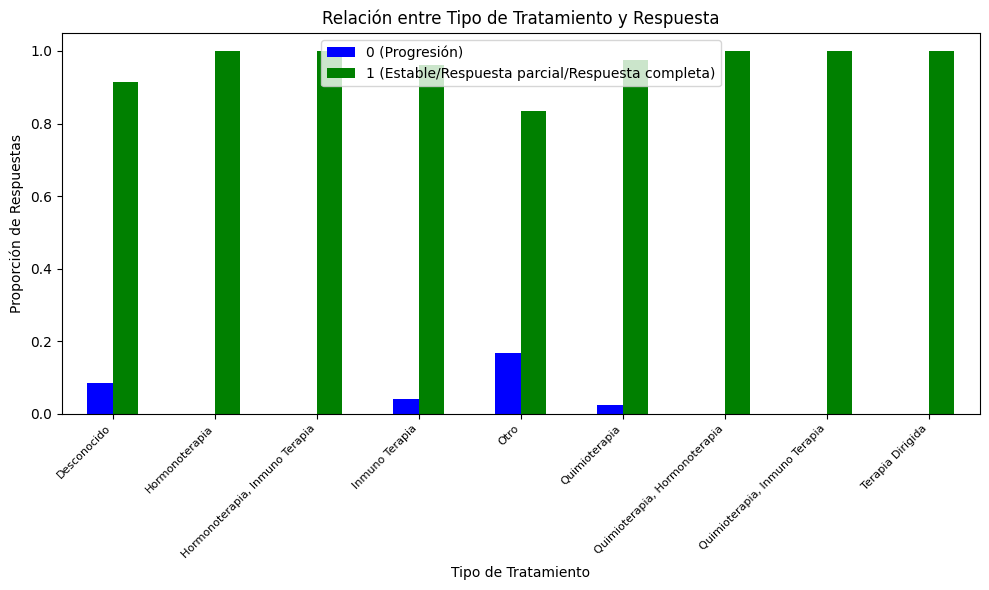

In [14]:

proportions_df = df.groupby('TIPO DE TX')['RESPUESTA_BINARIA'].value_counts(normalize=True).unstack().fillna(0)

# Crear un DataFrame con las proporciones para cada respuesta
proportions_df = df.groupby('TIPO DE TX')['RESPUESTA_BINARIA'].value_counts(normalize=True).unstack().fillna(0)

# Graficar las barras agrupadas
colors = ['blue', 'green']
proportions_df.plot(kind='bar', color=colors, figsize=(10, 6))
plt.title('Relación entre Tipo de Tratamiento y Respuesta')
plt.xlabel('Tipo de Tratamiento')
plt.ylabel('Proporción de Respuestas')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(labels=['0 (Progresión)', '1 (Estable/Respuesta parcial/Respuesta completa)'])
plt.tight_layout()
plt.show()
     

ANALISIS ENTRE DOSIS (Gy) (Cantidad de energía absorbida por un tejido debido a la radiación ionizante) y RESPUESTA AL TRATAMIENTO

In [15]:
df['DOSIS (Gy)'].unique()

array([16, 20, 22, 24,  8, 18,  7, 14, 15,  5,  9, 19,  6,  2, 21, 23,  3,
        4])

In [16]:
print (df['DOSIS (Gy)'].unique())

primer_cuartil = df['DOSIS (Gy)'].quantile(0.25)
tercer_cuartil = df['DOSIS (Gy)'].quantile(0.75)
IQR = tercer_cuartil - primer_cuartil

# Calcular los límites para considerar los valores atípicos 
limite_inferior = primer_cuartil - 1.5 * IQR
limite_superior = tercer_cuartil + 1.5 * IQR

# Filtrar los valores que están dentro de los límites
df = df[df['DOSIS (Gy)'].between(limite_inferior, limite_superior)]

[16 20 22 24  8 18  7 14 15  5  9 19  6  2 21 23  3  4]


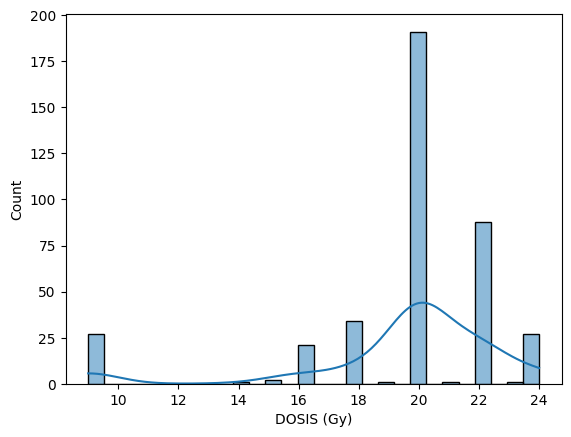

In [17]:
# Analizando la variable 'DOSIS (Gy)', iniciando con una grafica para conocer su distribución 
sns.histplot(df['DOSIS (Gy)'], kde=True)  # kde=True agrega una curva de densidad
plt.show()


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 80.2523
Valor p: 0.0000

Tabla de contingencia:
RESPUESTA (CRITERIOS RANO)  ESTABLE  PROGRESION  RESPUESTA COMPLETA  \
DOSIS (Gy)                                                            
9                                 7           1                   0   
14                                0           0                   0   
15                                1           1                   0   
16                                6           1                   3   
18                               10           0                  16   
19                                0           0                   0   
20                               73           7                  62   
21                                1           0                   0   
22                               30           0                  27   
23                                0           0                   0   
24                               19           0

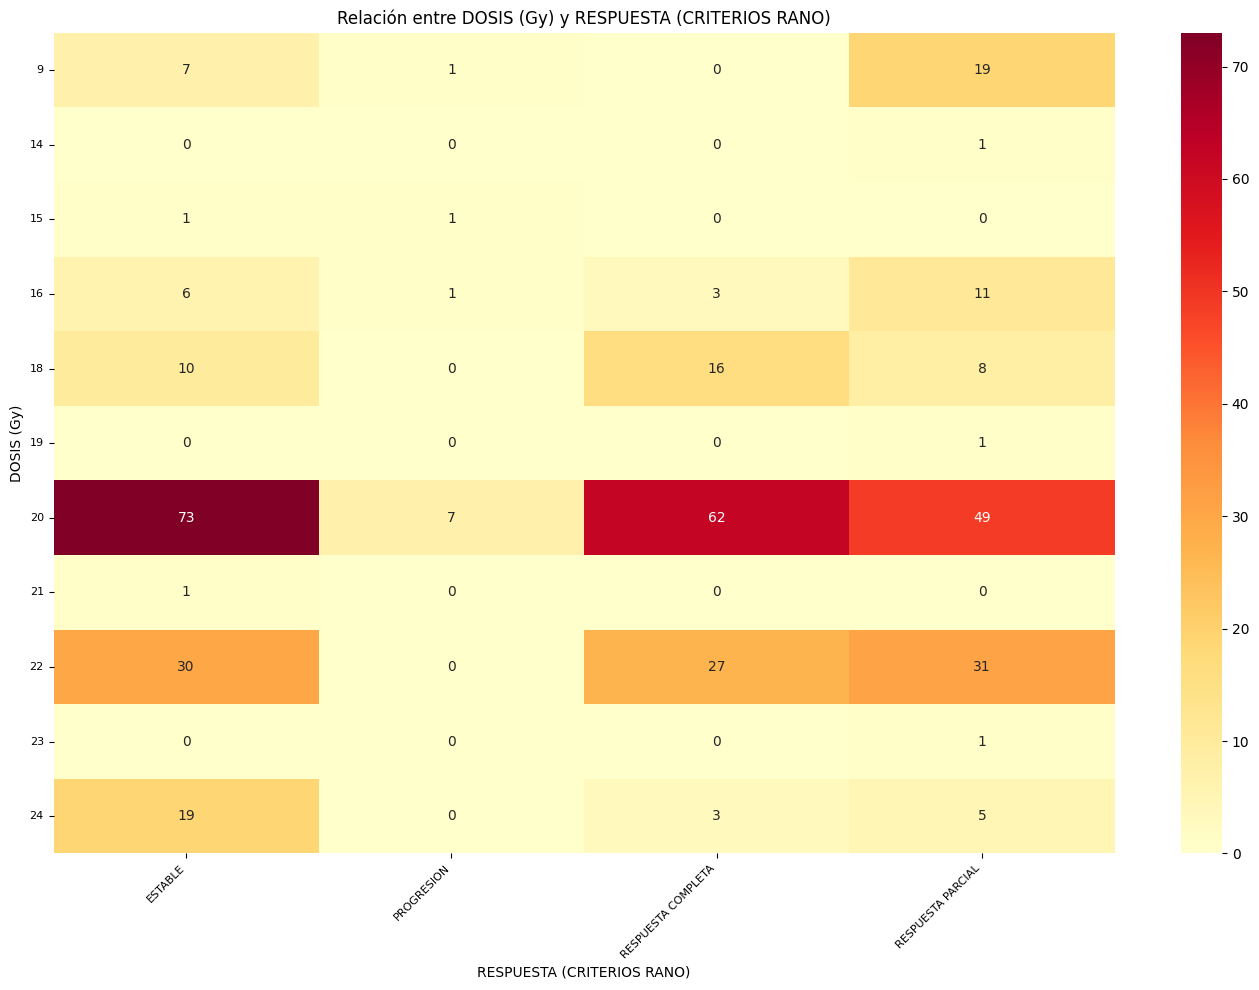

In [18]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['DOSIS (Gy)'], df['RESPUESTA (CRITERIOS RANO)'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre DOSIS (Gy) y RESPUESTA (CRITERIOS RANO)')
plt.xlabel('RESPUESTA (CRITERIOS RANO)')
plt.ylabel('DOSIS (Gy)')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

 Los resultados de la prueba de Chi-cuadrado sugieren que existe una asociación significativa entre la dosis y la respuesta. Esto significa que la dosis está relacionada con la probabilidad de tener una respuesta "Buena" o "Favorable".


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 23.7460
Valor p: 0.0083

Tabla de contingencia:
RESPUESTA_BINARIA  0    1
DOSIS (Gy)               
9                  1   26
14                 0    1
15                 1    1
16                 1   20
18                 0   34
19                 0    1
20                 7  184
21                 0    1
22                 0   88
23                 0    1
24                 0   27


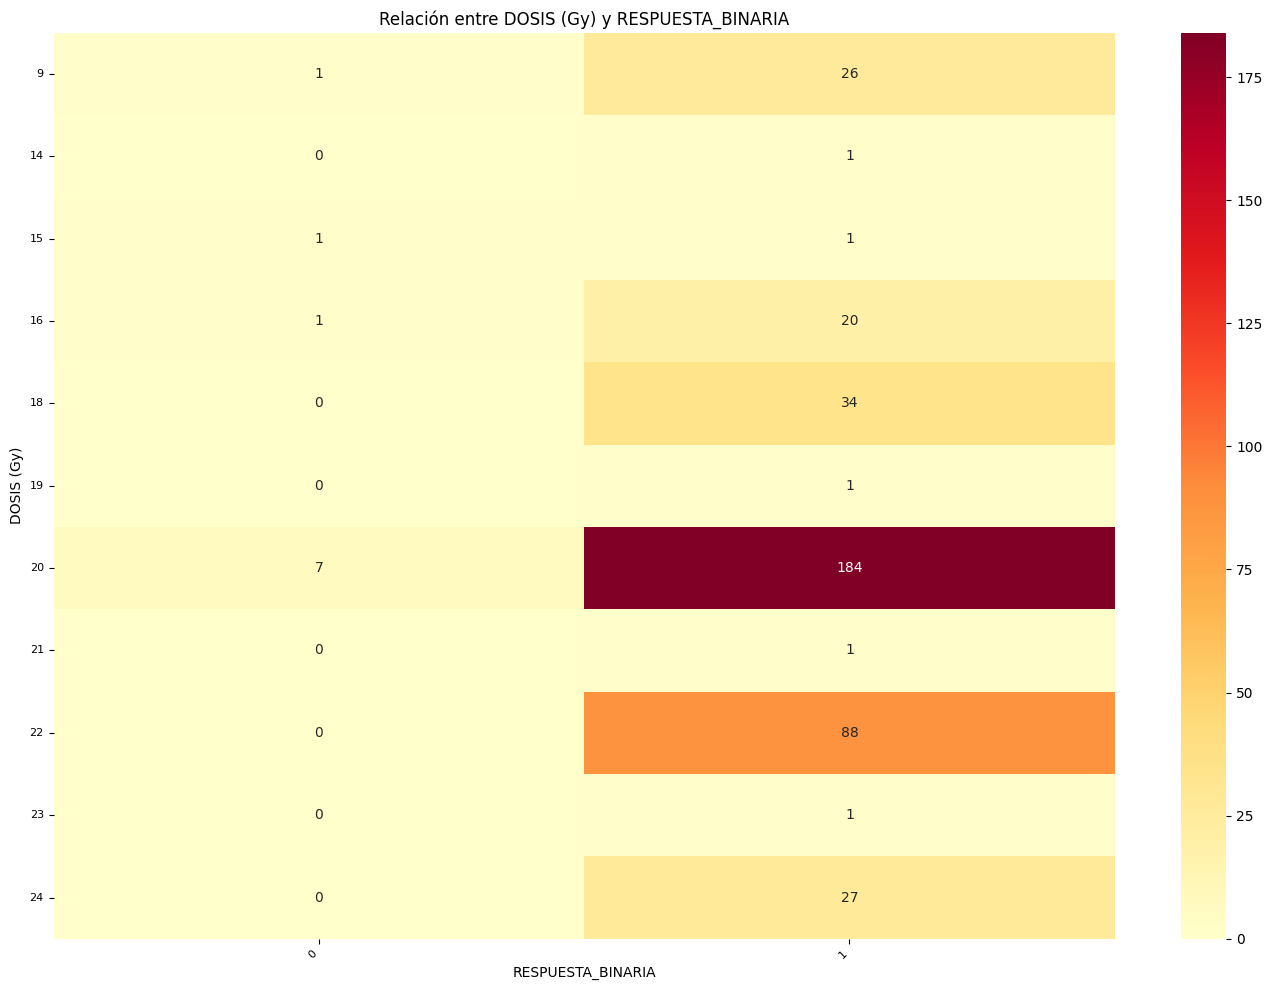

In [19]:
# Crear tabla de contingencia 
contingency_table = pd.crosstab(df['DOSIS (Gy)'], df['RESPUESTA_BINARIA'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre DOSIS (Gy) y RESPUESTA_BINARIA')
plt.xlabel('RESPUESTA_BINARIA')
plt.ylabel('DOSIS (Gy)')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()



Analisis con la variable PERFIL MOLECULAR

In [20]:
# Asignar a la columna 'PERFIL MOLECULAR' valor binario
def map_response(value):
    if value.strip().upper() in ['TRIPLE NEGATIVO','HER2+++','LUMINAL B','EGFR+',
 'AG EPITELIAL MEMBRANA +. CITOKERATINA +. VIMENTINA +','LUMINAL A',
 'HMB45 +++. S-100 +++. CITOQUERATINA -', 'ALK MUTADO',
 'CITOQUERATINA APM+++. AG EPITELIAL DE MEMBRANA+. VIMENTINA-', 'CA 125+',
 'CITOQUERATINA PA +++. RE-. RP-. P53+++. SMH2++. PTEM-']:
        return 1
    else:
        return 0

df['PERFIL_BIN'] = df['PERFIL MOLECULAR'].apply(map_response)
df


,EXPEDIENTE,EDAD,SEXO,TUMOR PRIMARIO,SUBTIPO HISTOLOGICO,PERFIL MOLECULAR,AÑO,No. METS,TAMAÑO (mm),LOCALIZACION,CIRUGIA PREVIA,SRS,DOSIS (Gy),TECNICA,TRATAMIENTO SISTEMICO,RESPUESTA (CRITERIOS RANO),ID_unico,RESPUESTA_BINARIA,TIPO DE TX,PERFIL_BIN
0,209406,55,F,CANCER DE MAMA,CARCINOMA DUCTAL INFILTRANTE,TRIPLE NEGATIVO,2016.0,1,26.00,PARIETAL IZQ,SI,DU (dosis única),16,VMAT,CAPECITABINE,RESPUESTA COMPLETA,arVYSawGyncamwxDvEFq2p,1,Quimioterapia,1
1,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,1,17.00,FRONTAL DER,NO,DU (dosis única),20,VMAT,SORAFENIB,ESTABLE,fXjbGDzCmb8uvRK9WLJVsF,1,Terapia Dirigida,0
2,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,2,4.55,FRONTAL DER,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,9jYiY9yM7nYu3k2CcnxQUz,1,Terapia Dirigida,0
3,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,3,3.44,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,RESPUESTA PARCIAL,i8VWomMqG92GyenK6f9vMJ,1,Terapia Dirigida,0
4,225523,56,M,CANCER RENAL,CARCINOMA DE CELULAS CLARAS,Unknown,2017.0,4,4.90,CEREBELO,NO,DU (dosis única),22,VMAT,PAZOPANIB,ESTABLE,E2BccD5k4nE3KBf7FvpeUa,1,Terapia Dirigida,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,299625,30,M,CANCER DE ESOFAGO,CARCINOMA DE CELULAS PEQUEÑAS,Unknown,2023.0,1,16.20,TEMPORAL IZQ,NO,HIPO FX,9,VMAT,PANITUMUMAB + FLUOROURACIL. LEUCOVORIN. IRINIT...,RESPUESTA PARCIAL,Hc6ehmKMWYKVhjMdAEJiub,1,Quimioterapia,0
461,299625,30,M,CANCER DE ESOFAGO,CARCINOMA DE CELULAS PEQUEÑAS,Unknown,2023.0,2,10.70,OCCIPITAL DER,NO,DU (dosis única),22,VMAT,PANITUMUMAB + FLUOROURACIL. LEUCOVORIN. IRINIT...,RESPUESTA COMPLETA,gTR8RPyd4s6JR2JMh58b9J,1,Quimioterapia,0
462,287642,64,F,CANCER DE PULMON,CARCINOMA POCO DIFERENCIADO,Unknown,2023.0,1,21.30,FRONTAL IZQ,NO,DU (dosis única),16,VMAT,AFATINIB,RESPUESTA PARCIAL,Hk53cJYtiTzioTEkZm5UpX,1,Terapia Dirigida,0
463,287642,64,F,CANCER DE PULMON,CARCINOMA POCO DIFERENCIADO,Unknown,2023.0,2,15.50,TEMPORAL DER,NO,DU (dosis única),22,VMAT,AFATINIB,RESPUESTA PARCIAL,gFqa6XfM5CLpkZmjVyeyeF,1,Terapia Dirigida,0


In [21]:
# Crear una columna de ID única
df['ID'] = range(1, len(df) + 1)

# Reordenar columnas para que 'ID' esté al principio (opcional)
cols = ['ID'] + [col for col in df.columns if col != 'ID']
df = df[cols]


In [22]:
df.to_excel('base-completa.xlsx')

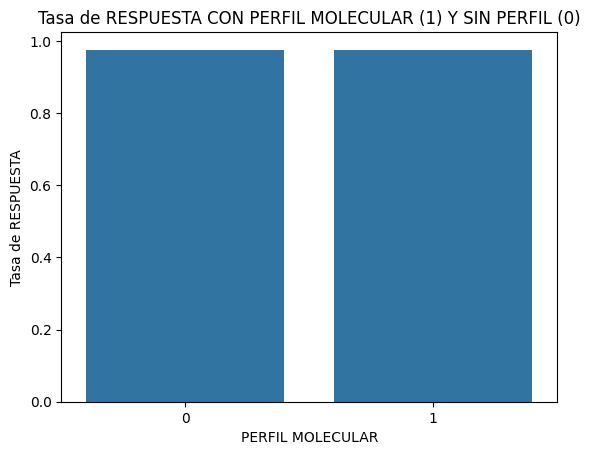

Resultado del test Chi-squared:
Chi2: 0.0
p-value: 1.0
Grados de libertad: 1
Frecuencias esperadas:
[[  4.11167513 157.88832487]
 [  5.88832487 226.11167513]]


In [23]:
#Agrupar datos por PERFIL_BIN 
grouped_data = df.groupby('PERFIL_BIN')['RESPUESTA_BINARIA'].mean()

# Realizar prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df['PERFIL_BIN'], df['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizar resultados
sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('Tasa de RESPUESTA CON PERFIL MOLECULAR (1) Y SIN PERFIL (0)')
plt.xlabel('PERFIL MOLECULAR')
plt.ylabel('Tasa de RESPUESTA')
plt.show()

#Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Conn base en el  valor p, se concluye que no existe una asociación estadísticamente significativa entre las dos variables, es decir las variables son independientes.

Analisis de la relación entre la variable SRS y la respuesta al tratamiento.

In [24]:
print(df['SRS'].unique())


['DU (dosis única)' 'Unknown' 'HIPO FX']


In [25]:
# Crear la tabla de contingencia
contingencia = pd.crosstab(df['SRS'], df['RESPUESTA_BINARIA'])
print(contingencia)

RESPUESTA_BINARIA  0    1
SRS                      
DU (dosis única)   9  357
HIPO FX            1   26
Unknown            0    1


In [26]:
filtered_df = df[(df['SRS'] == 'CONV') | (df['SRS'] == 'Unknown')]
print(filtered_df )

    ID  EXPEDIENTE  EDAD SEXO    TUMOR PRIMARIO    SUBTIPO HISTOLOGICO  \
15  14      232385    46    M  CANCER DE PULMON  ADENOCARCINOMA ACINAR   

   PERFIL MOLECULAR     AÑO  No. METS  TAMAÑO (mm)  ... CIRUGIA PREVIA  \
15          Unknown  2017.0         1         21.0  ...             SI   

        SRS DOSIS (Gy)  TECNICA  TRATAMIENTO SISTEMICO  \
15  Unknown         20      VMAT               Unknown   

   RESPUESTA (CRITERIOS RANO)                ID_unico RESPUESTA_BINARIA  \
15         RESPUESTA COMPLETA  W8dbPpRTcaZLGQCs7FKN9d                 1   

     TIPO DE TX PERFIL_BIN  
15  Desconocido          0  

[1 rows x 21 columns]


In [27]:
# Crea una máscara booleana para identificar las filas a eliminar
mask = df['SRS'].isin(['CONV', 'Unknown'])

# Elimina las filas usando la máscara y el método drop()
df = df[~mask]  # El operador ~ invierte la máscara para seleccionar las filas que NO cumplen la condición

# Restablece el índice del DataFrame (opcional)
df.reset_index(drop=True, inplace=True)

In [28]:
#Evaluando si existe asociación significativa entre las dos variables

# Aplicar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

# Resultados
print(f"Chi2: {chi2}")
print(f"p-value: {p}")
print(f"Grados de libertad: {dof}")
print("Frecuencias esperadas:")
print(expected)

Chi2: 0.18359106203197742
p-value: 0.9122916658260768
Grados de libertad: 2
Frecuencias esperadas:
[[9.28934010e+00 3.56710660e+02]
 [6.85279188e-01 2.63147208e+01]
 [2.53807107e-02 9.74619289e-01]]


No hay suficiente evidencia para concluir que las variables estan relacionadas.

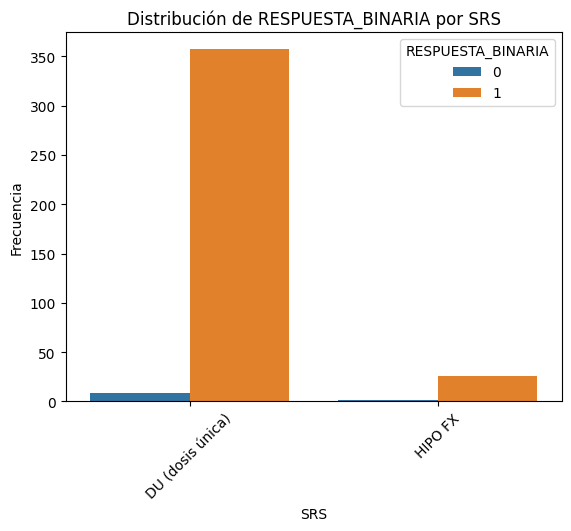

In [29]:
# Gráfico de barras agrupado
sns.countplot(data=df, x='SRS', hue='RESPUESTA_BINARIA')
plt.title('Distribución de RESPUESTA_BINARIA por SRS')
plt.xlabel('SRS')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 0.0000
Valor p: 1.0000

Tabla de contingencia:
RESPUESTA_BINARIA  0    1
SRS                      
DU (dosis única)   9  357
HIPO FX            1   26


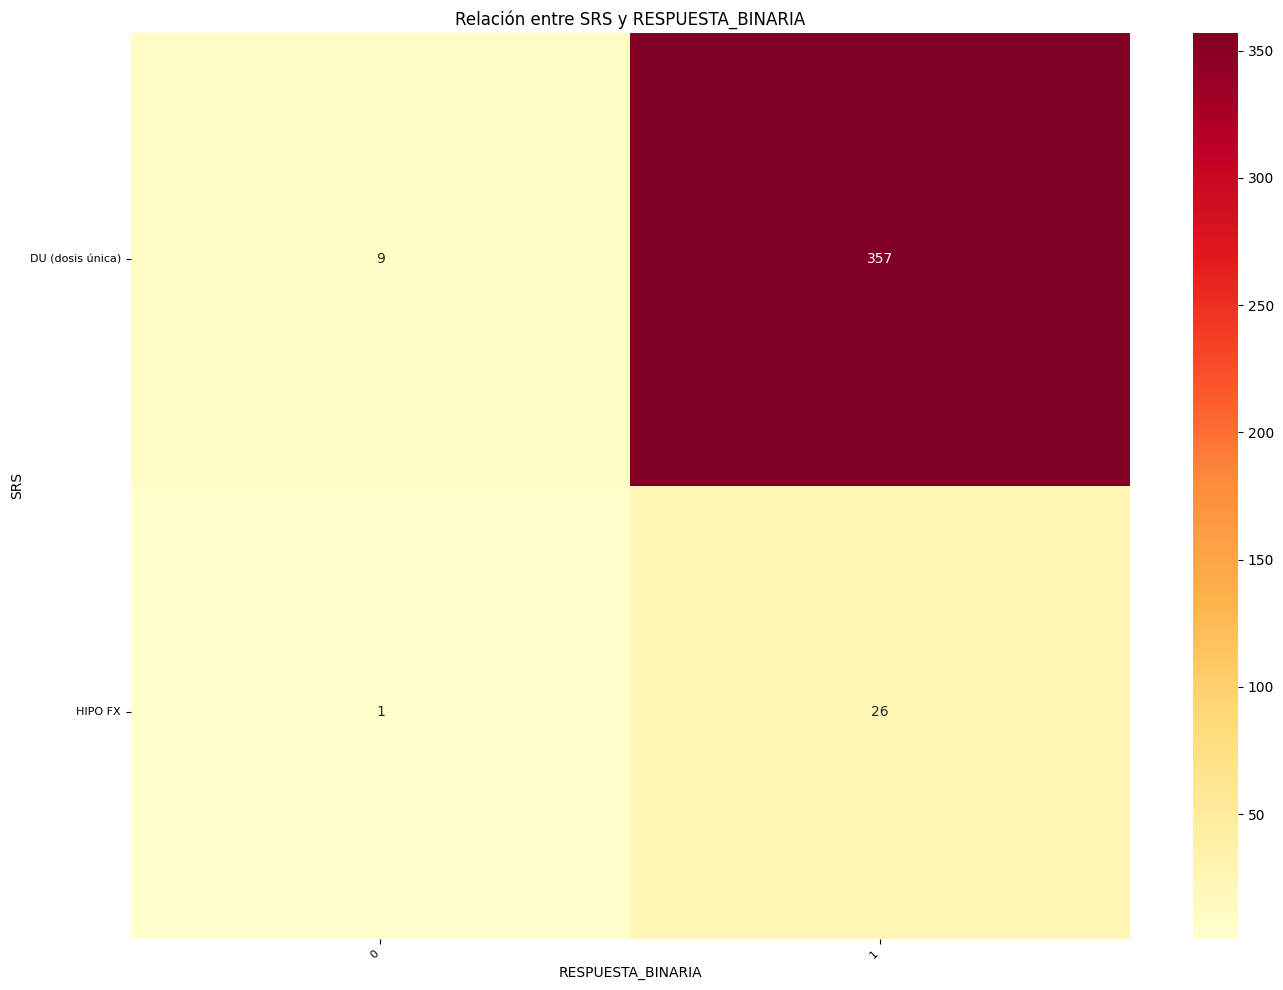

In [30]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['SRS'], df['RESPUESTA_BINARIA'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre SRS y RESPUESTA_BINARIA')
plt.xlabel('RESPUESTA_BINARIA')
plt.ylabel('SRS')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

ANALISIS CON LA VARIABLE TECNICA

In [31]:
df.columns = df.columns.str.strip()  # Elimina espacios al inicio y final
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Reemplaza espacios por guiones bajos

print(df.columns)

Index(['ID', 'EXPEDIENTE', 'EDAD', 'SEXO', 'TUMOR_PRIMARIO',
       'SUBTIPO_HISTOLOGICO', 'PERFIL_MOLECULAR', 'AÑO', 'No._METS',
       'TAMAÑO_(mm)', 'LOCALIZACION', 'CIRUGIA_PREVIA', 'SRS', 'DOSIS_(Gy)',
       'TECNICA', 'TRATAMIENTO_SISTEMICO', 'RESPUESTA_(CRITERIOS_RANO)',
       'ID_unico', 'RESPUESTA_BINARIA', 'TIPO_DE_TX', 'PERFIL_BIN'],
      dtype='object')


In [32]:
df['TECNICA'].unique()

array(['VMAT', 'CEC', 'CONO', 'IMRT', 'CONOS', 'RAPID ARC'], dtype=object)

In [33]:
df['TECNICA'] = df['TECNICA'].replace('CONOS', 'CONO')
df['TECNICA'].unique()

array(['VMAT', 'CEC', 'CONO', 'IMRT', 'RAPID ARC'], dtype=object)


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 23.7852
Valor p: 0.0001

Tabla de contingencia:
RESPUESTA_BINARIA  0    1
TECNICA                  
CEC                7   53
CONO               0    4
IMRT               0    2
RAPID ARC          0    1
VMAT               3  323


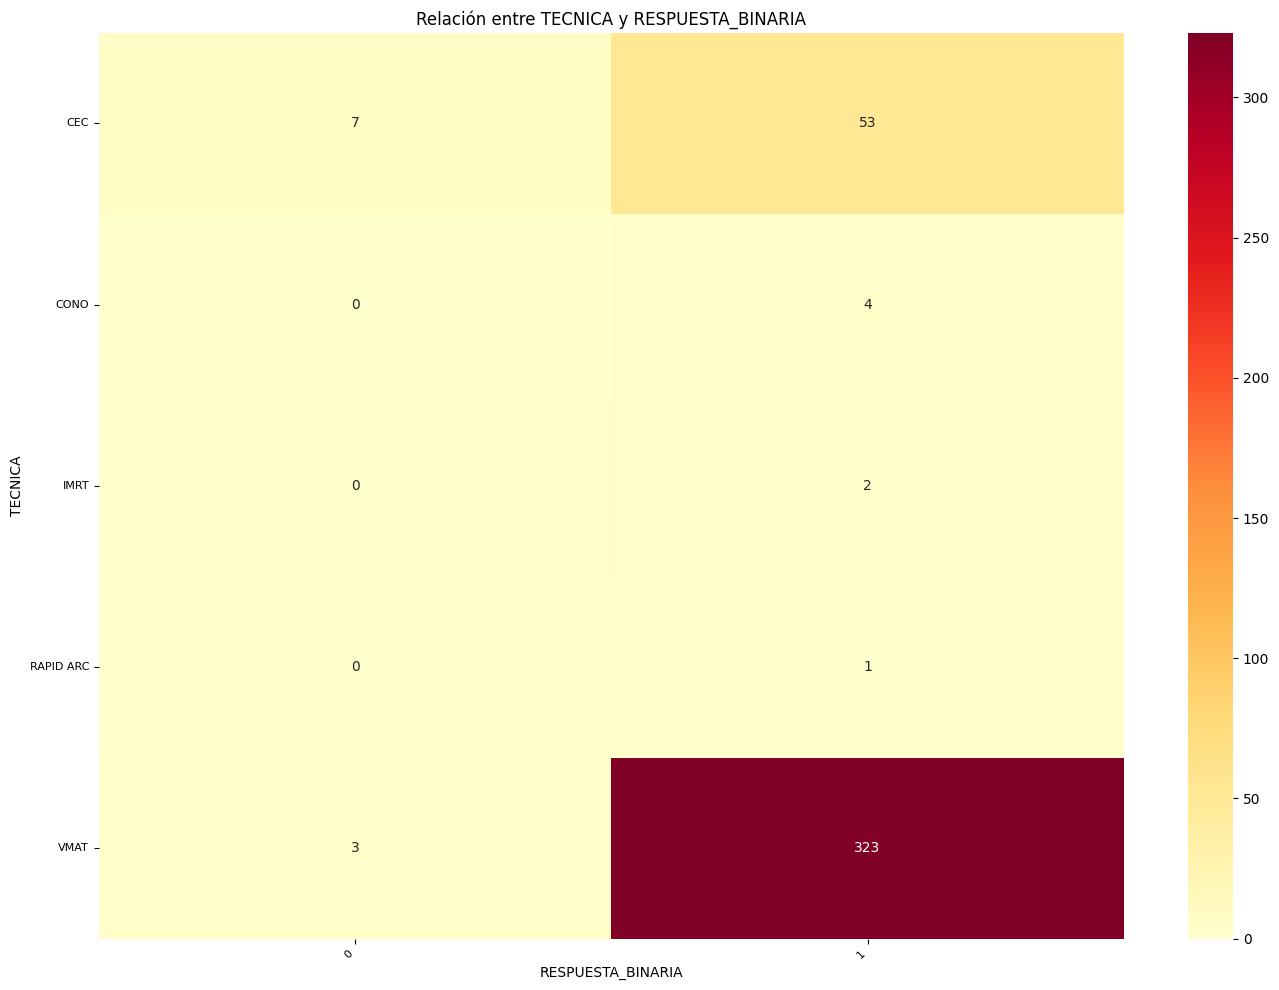

In [34]:
# Crear tabla de contingencia 
contingency_table = pd.crosstab(df['TECNICA'], df['RESPUESTA_BINARIA'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre TECNICA y RESPUESTA_BINARIA')
plt.xlabel('RESPUESTA_BINARIA')
plt.ylabel('TECNICA')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

In [35]:
# Creando una variable binaria para la variable tecnica, usando la moda VMAR como 1 y el resto 0

df['TEC_binaria'] = np.where(df['TECNICA'] == 'VMAT', 1, 0)


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 16.6837
Valor p: 0.0000

Tabla de contingencia:
RESPUESTA_BINARIA  0    1
TEC_binaria              
0                  7   60
1                  3  323


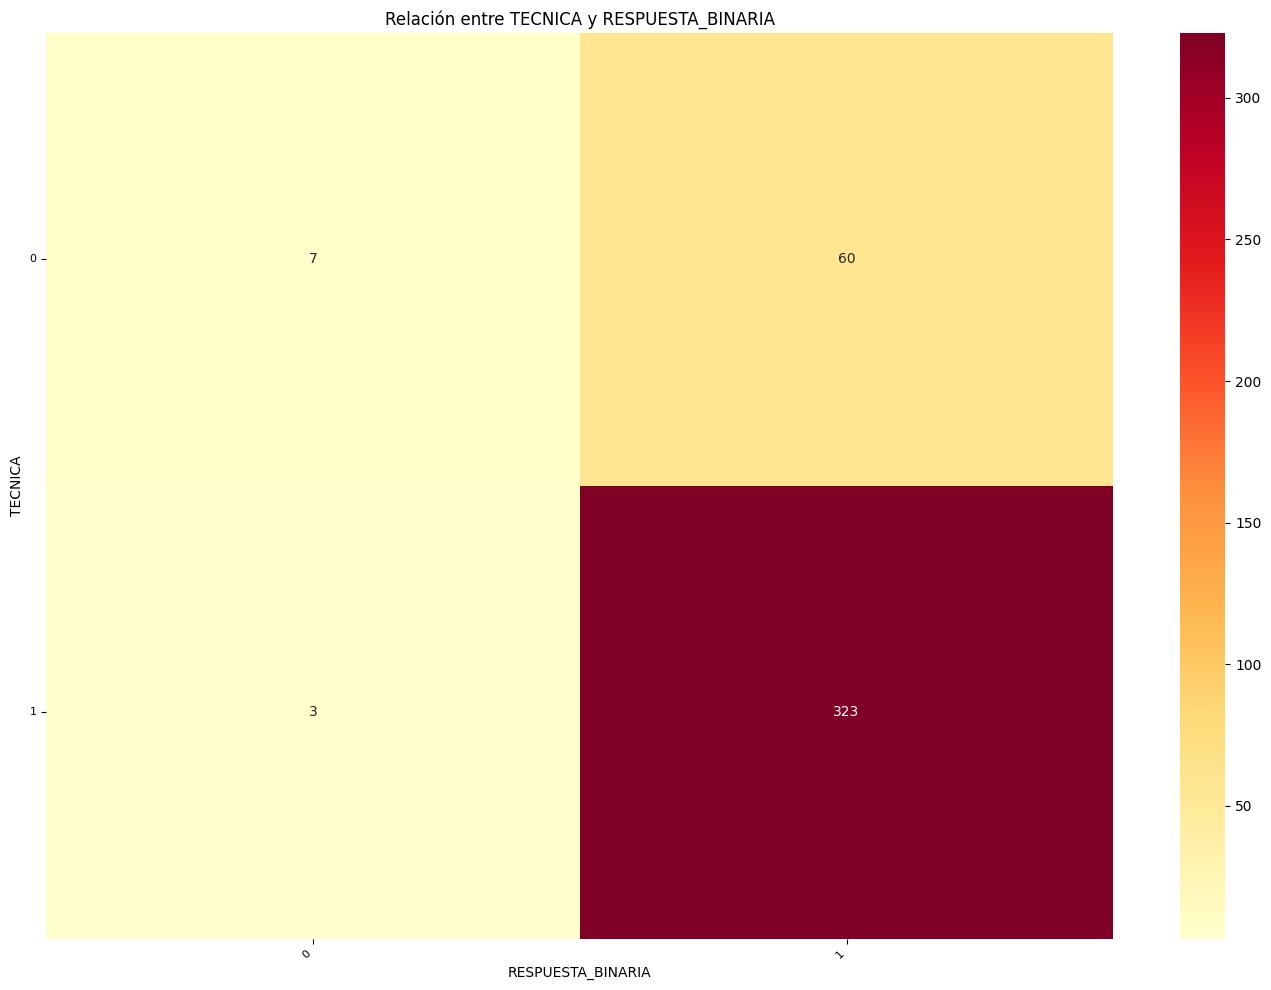

In [36]:
# Crear tabla de contingencia entre la variable  TECNICA BINARIA Y LA RESPUESTA BINARIA
contingency_table = pd.crosstab(df['TEC_binaria'], df['RESPUESTA_BINARIA'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre TECNICA y RESPUESTA_BINARIA')
plt.xlabel('RESPUESTA_BINARIA')
plt.ylabel('TECNICA')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

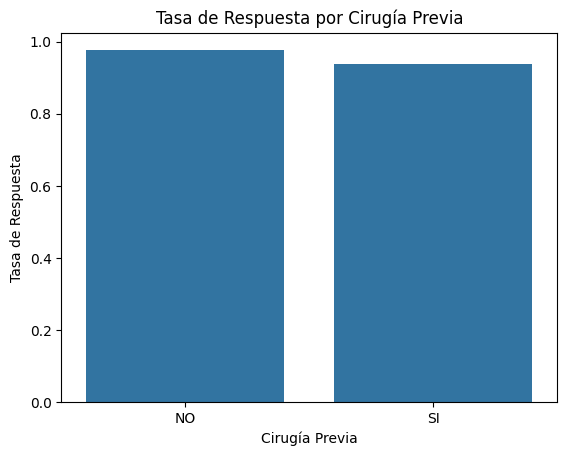

Resultado del test Chi-squared:
Chi2: 0.022663040373014944
p-value: 0.8803366329264115
Grados de libertad: 1
Frecuencias esperadas:
[[  9.59287532 367.40712468]
 [  0.40712468  15.59287532]]


In [37]:
# Agrupar datos por 'CIRUGIA PREVIA' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df.groupby('CIRUGIA_PREVIA')['RESPUESTA_BINARIA'].mean()

# Realizar prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df['CIRUGIA_PREVIA'], df['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizar resultados
sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('Tasa de Respuesta por Cirugía Previa')
plt.xlabel('Cirugía Previa')
plt.ylabel('Tasa de Respuesta')
plt.show()

#Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Se concluye a partir de los resultados de la prueba de chi-cuadrado (valor p = 0.88033> 0,05), no hay diferencia estadísticamente significativa en las tasas de respuesta entre pacientes con y sin cirugía previa. La visualización muestra proporciones de respuesta similares entre ambos grupos.

RESULTADOS DEL ANALISIS DE LAS VARIABLES CON RESPECTO A LA RESPUESTA AL TRATAMIENTO
Se analizaron las siguientes variables, TUMOR PRIMARIO, SUBTIPO HISTOLOGICO, CIRUGIA PREVIA, PERFIL MOLECULAR, TRATAMIENTO SISTEMICO , DOSIS (Gy), SRS, Y TECNICA. Como resultado de las diferentes pruebas AB Testing, se encontró que TRATAMIENTO SISTEMICO , DOSIS (Gy), SUTIPO HISTOLOGICO y TECNICA cirugía mostraron una asociación estadísticamente significativa con la respuesta al tratamiento.

Por otro lado, el análisis mediante la prueba de chi-cuadrado reveló una relación que no es estadísticamente significativa entre las demás variables y la respuesta binaria al tratamiento.

RESPUESTA_BINARIA
1    383
0     10
Name: count, dtype: int64
RESPUESTA_BINARIA
1    0.974555
0    0.025445
Name: proportion, dtype: float64


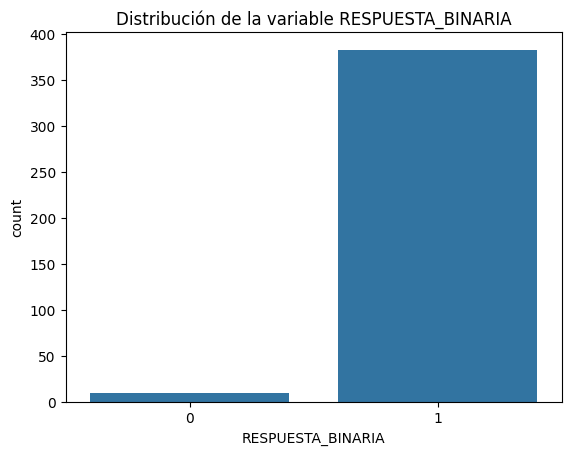

In [38]:
#Analisis para revisar si existe desbalance de clases 
# # Ver distribución de las clases
print(df['RESPUESTA_BINARIA'].value_counts())

# Ver proporciones
print(df['RESPUESTA_BINARIA'].value_counts(normalize=True))

sns.countplot(x='RESPUESTA_BINARIA', data=df)
plt.title("Distribución de la variable RESPUESTA_BINARIA")
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          393 non-null    int64  
 1   EXPEDIENTE                  393 non-null    int64  
 2   EDAD                        393 non-null    int64  
 3   SEXO                        393 non-null    object 
 4   TUMOR_PRIMARIO              393 non-null    object 
 5   SUBTIPO_HISTOLOGICO         393 non-null    object 
 6   PERFIL_MOLECULAR            393 non-null    object 
 7   AÑO                         393 non-null    float64
 8   No._METS                    393 non-null    object 
 9   TAMAÑO_(mm)                 393 non-null    float64
 10  LOCALIZACION                393 non-null    object 
 11  CIRUGIA_PREVIA              393 non-null    object 
 12  SRS                         393 non-null    object 
 13  DOSIS_(Gy)                  393 non

Decidimos eliminar algunas columnas la RESPUESTA (CRITERIOS RANO), por ser redundante con la variable objetivo RESPUESTA_BINARIA lo que introduce un sobreajuste en el modelo. Las siguientes a eliminar son el PERFIL MOLECULAR Y LA CIRUGIA PREVIA por haber identificado previemente que no tienen reelevancia estadistica con la variable objetivo. Asimimso las variables binarias que se generaron para analisis previos. 

ANALISIS MULTIVARIADO
Vamos a realizar un primer anális para determinar la importancia de las variables en la respuesta al tratamiento. Utilizando el metodo Feature importance con el modelo Random Forest

In [40]:
# 1️⃣ Eliminar columnas irrelevantes (ID, EXPEDIENTE, ID_unico)
columnas_a_eliminar = ['ID', 'EXPEDIENTE', 'ID_unico', 'PERFIL_MOLECULAR', 'AÑO', 'CIRUGIA_PREVIA', 'SRS', "RESPUESTA_(CRITERIOS_RANO)", 'TRATAMIENTO_SISTEMICO', 'PERFIL_BIN', 'TEC_binaria']

df = df.drop(columns=columnas_a_eliminar, errors='ignore')

# 2️⃣ Identificar variables categóricas
columnas_categoricas = df.select_dtypes(include='object').columns

# 3️⃣ Codificar variables categóricas con OrdinalEncoder
encoder = OrdinalEncoder()
df[columnas_categoricas] = encoder.fit_transform(df[columnas_categoricas])

# Guardar el encoder en la misma carpeta que el modelo
joblib.dump(encoder, "/home/saul/Escritorio/ROSY/Metastasis/ordinal_encoder.pkl")


# 4️⃣ Definir variables predictoras (X) y la variable objetivo (y)
X = df.drop(columns=["RESPUESTA_BINARIA"])  # Variables predictoras
y = df["RESPUESTA_BINARIA"]  # Variable objetivo

# 5️⃣ Entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# 6️⃣ Obtener importancia de las variables
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# 7️⃣ Mostrar los resultados
print("Importancia de las variables:")
print(feature_importance)


Importancia de las variables:
TAMAÑO_(mm)            0.242419
LOCALIZACION           0.152654
EDAD                   0.130126
No._METS               0.124689
DOSIS_(Gy)             0.088609
TECNICA                0.083426
SUBTIPO_HISTOLOGICO    0.066866
TIPO_DE_TX             0.059179
TUMOR_PRIMARIO         0.040882
SEXO                   0.011151
dtype: float64


RESULTADO DEL ANALIS MULTIVARIADO
    Despues de realizar el analisis multivariado, se concluye que la variables se pueden agrupar en dos tipos, un grupo relacionado direcamente con las carateristicas del paciente, como edod, sexo, tipo de tumor primario , nomero de tumores metastásicos, tamaño de los mismos, en este grupo resalta el TUMOR PRIMARIO y otro grupo de variables relacionadas con el tratamiendo en donde las mas reelevantes fueron en  relación con la respuesta al tratamiento es la DOSIS (Gy), la TECNICA, y el TIPO DE TX SISTEMICO .

MODELOS PREDICTIVOS 

In [41]:
df.to_csv("/home/saul/Escritorio/ROSY/Metastasis/dftrain.csv", index=False)

Antes de entrenar el modelo procederemos a balancear la clase minoritaria

In [42]:
# Separar X e y
X = df.drop(columns=["RESPUESTA_BINARIA"])
y = df["RESPUESTA_BINARIA"]

# Aplicar SMOTE para balancear la clase minoritaria
smote = SMOTE(sampling_strategy=0.4, random_state=42)  # La clase minoritaria será el 
X_resampled, y_resampled = smote.fit_resample(X, y)

# Ver distribución después del balanceo
print("Distribución después del balanceo:")
print(y_resampled.value_counts(normalize=True))

# Dividir los datos balanceados en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=42)

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Guardar el modelo entrenado en la misma ruta
joblib.dump(rf_model, "/home/saul/Escritorio/ROSY/Metastasis/rfc_model.pkl")


# Realizar predicciones sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Distribución después del balanceo:
RESPUESTA_BINARIA
1    0.714552
0    0.285448
Name: proportion, dtype: float64
Matriz de confusión:
[[ 51   2]
 [  2 106]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.98      0.98      0.98       108

    accuracy                           0.98       161
   macro avg       0.97      0.97      0.97       161
weighted avg       0.98      0.98      0.98       161



In [43]:
# Crear el modelo XGBoost con scale_pos_weight ajustado
# scale_pos_weight debe reflejar el desbalanceo de clases. Para ajustarlo, calcula la proporción de clases
class_0_count = y.value_counts()[0]
class_1_count = y.value_counts()[1]

# Ajustar el parámetro scale_pos_weight según la relación entre las clases
scale_pos_weight = class_0_count / class_1_count

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Matriz de confusión:
 [[ 0  0]
 [14 65]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90        79

    accuracy                           0.82        79
   macro avg       0.50      0.41      0.45        79
weighted avg       1.00      0.82      0.90        79



/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Ajustar el parámetro scale_pos_weight en XGBoost
model = xgb.XGBClassifier(scale_pos_weight=10, random_state=42)  # Ajusta el peso de la clase minoritaria

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = model.predict(X_test)
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Matriz de confusión:
 [[32  3]
 [ 2 71]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.96      0.97      0.97        73

    accuracy                           0.95       108
   macro avg       0.95      0.94      0.95       108
weighted avg       0.95      0.95      0.95       108



In [45]:
# Realizar validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Precisión media en validación cruzada: {np.mean(cv_scores)}")

Precisión media en validación cruzada: 0.9650068399452805


    RESULTADO DEL ENTRENAMIENTO DE MODELOS PREDICTIVOS
    Despues de realizar el entrenamiento de varios modelos predictivos, decidimos elegir el modelo RandomForestClassifier, el cual nos predice la respuesta al tratamiento con una exactitd el 98 %. El modelo XGBClassifier, tambien resulta una buena opción con un 95% de exactitud.